# Cancer-Regression-Analysis

# Imports

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway, anderson


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# Functions

In [9]:
def check_nulls_dupes(df):
  print(f"Number of Nulls: {df.isna().sum()}")
  print(f"Number of Duplicates: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()
  
def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/cancer_reg.csv")
df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


# Check For Nulls And Dupes

In [6]:
check_nulls_dupes(df)

Number of Nulls: avganncount                   0
avgdeathsperyear              0
target_deathrate              0
incidencerate                 0
medincome                     0
popest2015                    0
povertypercent                0
studypercap                   0
binnedinc                     0
medianage                     0
medianagemale                 0
medianagefemale               0
geography                     0
percentmarried                0
pctnohs18_24                  0
pcths18_24                    0
pctsomecol18_24            2285
pctbachdeg18_24               0
pcths25_over                  0
pctbachdeg25_over             0
pctemployed16_over          152
pctunemployed16_over          0
pctprivatecoverage            0
pctprivatecoveragealone     609
pctempprivcoverage            0
pctpubliccoverage             0
pctpubliccoveragealone        0
pctwhite                      0
pctblack                      0
pctasian                      0
pctotherrace           

In [8]:
df.dtypes

avganncount                float64
avgdeathsperyear             int64
target_deathrate           float64
incidencerate              float64
medincome                    int64
popest2015                   int64
povertypercent             float64
studypercap                float64
binnedinc                   object
medianage                  float64
medianagemale              float64
medianagefemale            float64
geography                   object
percentmarried             float64
pctnohs18_24               float64
pcths18_24                 float64
pctsomecol18_24            float64
pctbachdeg18_24            float64
pcths25_over               float64
pctbachdeg25_over          float64
pctemployed16_over         float64
pctunemployed16_over       float64
pctprivatecoverage         float64
pctprivatecoveragealone    float64
pctempprivcoverage         float64
pctpubliccoverage          float64
pctpubliccoveragealone     float64
pctwhite                   float64
pctblack            

In [22]:
df.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,...,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,48878.118280,45.272333,...,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,16889.719362,45.304480,...,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,28429.050000,22.300000,...,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,38888.250000,37.700000,...,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,46611.300000,41.000000,...,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,52796.000000,44.000000,...,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,93564.750000,624.000000,...,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165


In [7]:
missing_columns = [
  'pctsomecol18_24', # Mean
  'pctemployed16_over', # Mean
  'pctprivatecoveragealone' # # Mean
]

In [23]:
for col in missing_columns:
  df[col] = df[col].fillna(df[col].mean())

In [11]:
categorical_types = df.select_dtypes(include="object")

for col in categorical_types:
  print(categorical_types[col].value_counts())

(54545.6, 61494.5]    306
[22640, 34218.1]      306
(45201, 48021.6]      306
(48021.6, 51046.4]    305
(42724.4, 45201]      305
(51046.4, 54545.6]    305
(37413.8, 40362.7]    304
(40362.7, 42724.4]    304
(34218.1, 37413.8]    304
(61494.5, 125635]     302
Name: binnedinc, dtype: int64
Kitsap County, Washington            1
Ralls County, Missouri               1
Pemiscot County, Missouri            1
Perry County, Missouri               1
Pettis County, Missouri              1
                                    ..
San Bernardino County, California    1
Cullman County, Alabama              1
San Diego County, California         1
San Francisco County, California     1
Geary County, Kansas                 1
Name: geography, Length: 3047, dtype: int64


In [18]:
def binned_income(val):
  
  val = re.sub(r'[^\d.,]', '', val)
  val_1, val_2 = val.split(",")
  return (float(val_1) + float(val_2)) / 2

df['binnedinc'] = df["binnedinc"].apply(binned_income)

In [19]:
df.dtypes

avganncount                float64
avgdeathsperyear             int64
target_deathrate           float64
incidencerate              float64
medincome                    int64
popest2015                   int64
povertypercent             float64
studypercap                float64
binnedinc                  float64
medianage                  float64
medianagemale              float64
medianagefemale            float64
geography                   object
percentmarried             float64
pctnohs18_24               float64
pcths18_24                 float64
pctsomecol18_24            float64
pctbachdeg18_24            float64
pcths25_over               float64
pctbachdeg25_over          float64
pctemployed16_over         float64
pctunemployed16_over       float64
pctprivatecoverage         float64
pctprivatecoveragealone    float64
pctempprivcoverage         float64
pctpubliccoverage          float64
pctpubliccoveragealone     float64
pctwhite                   float64
pctblack            

# Visuals

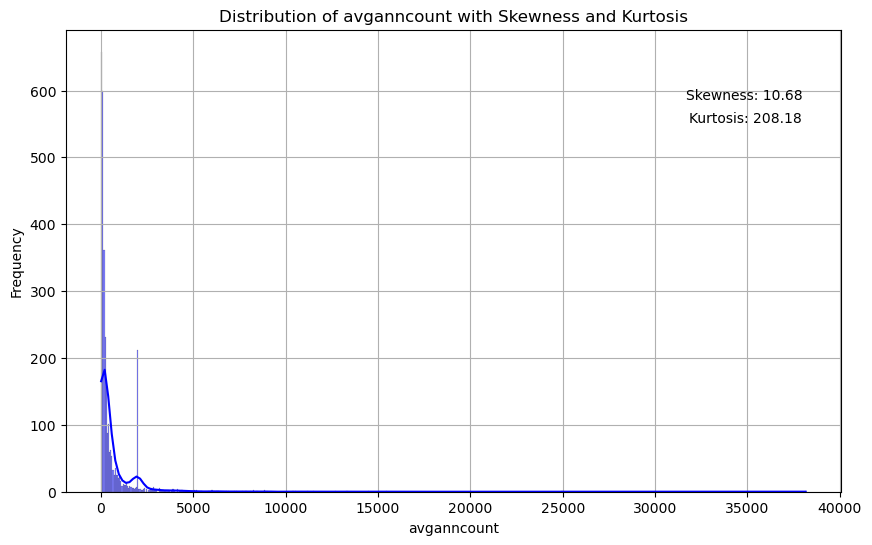

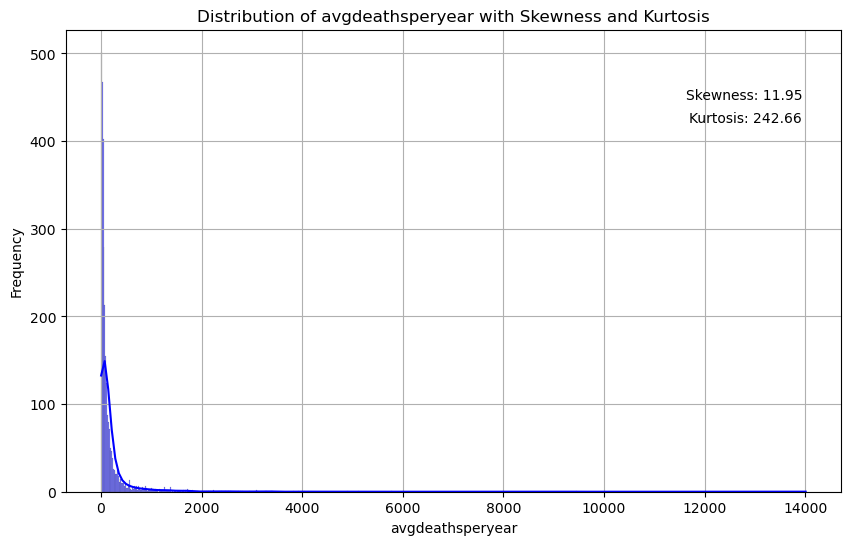

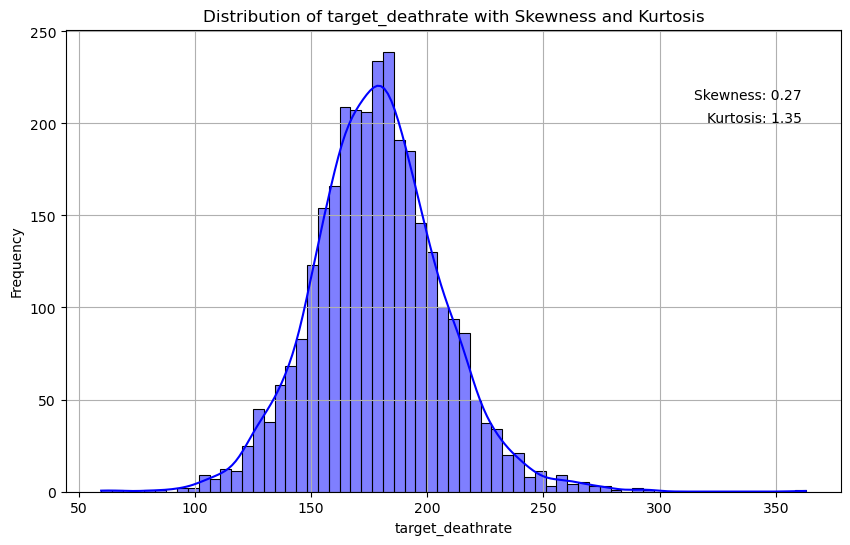

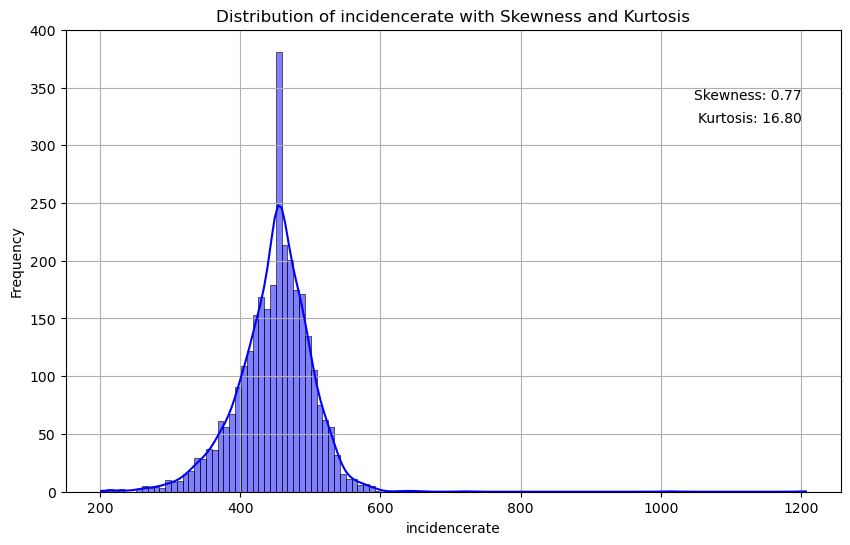

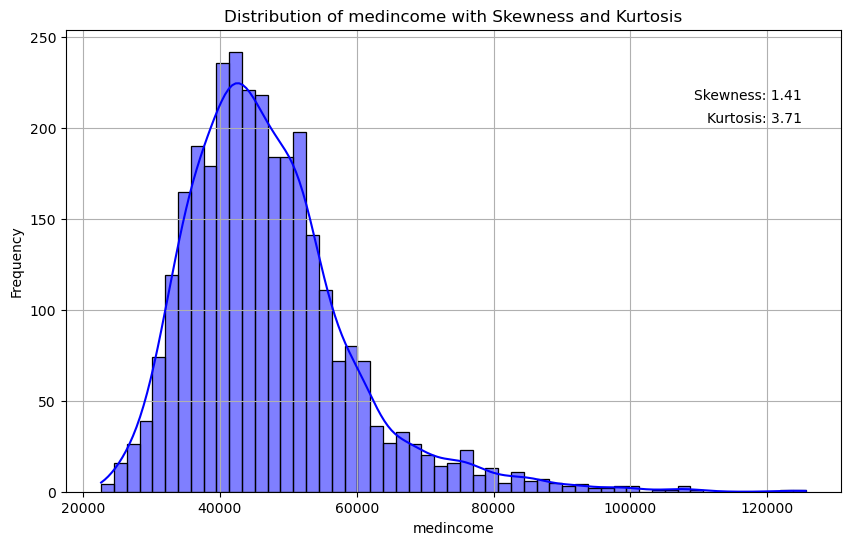

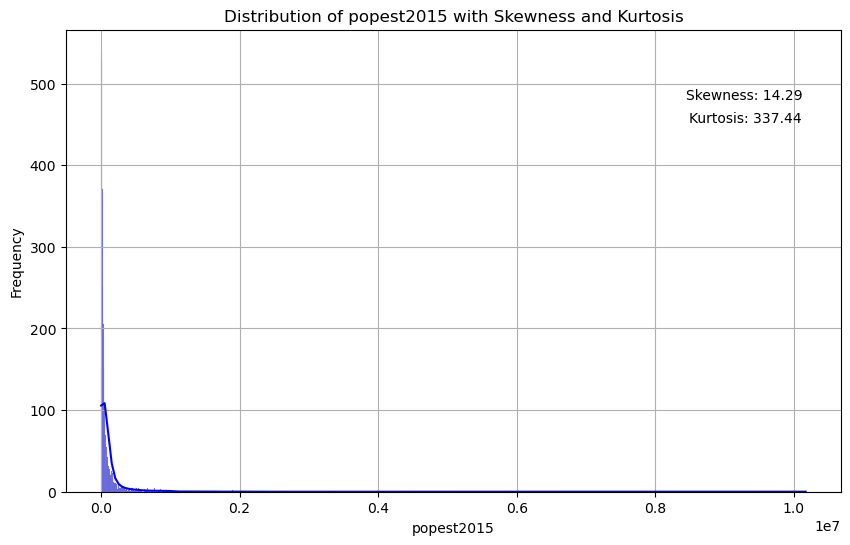

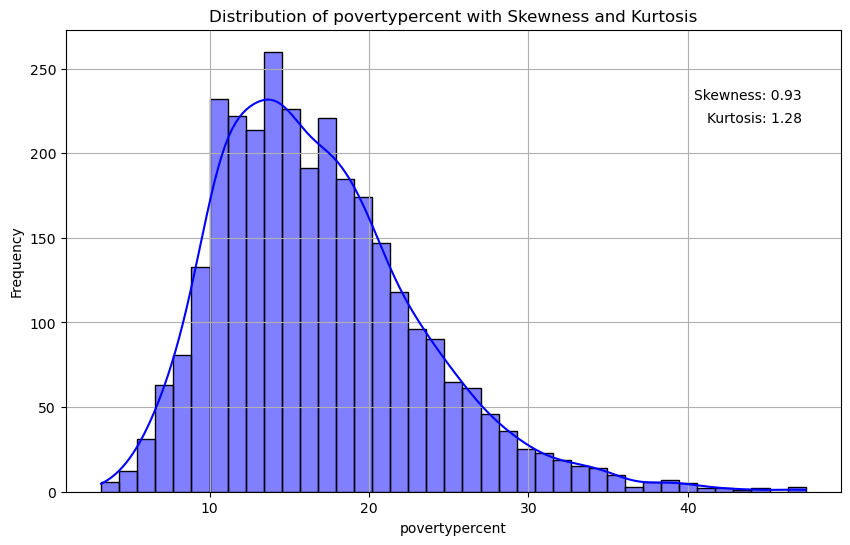

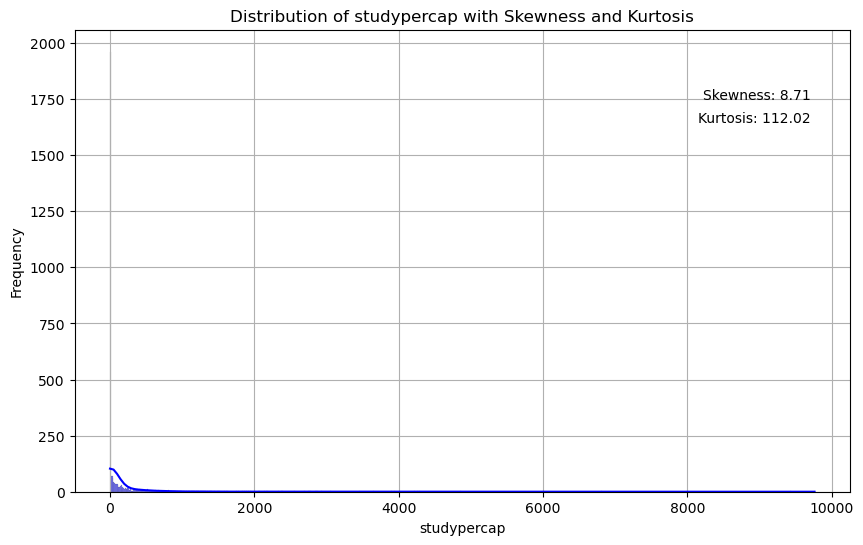

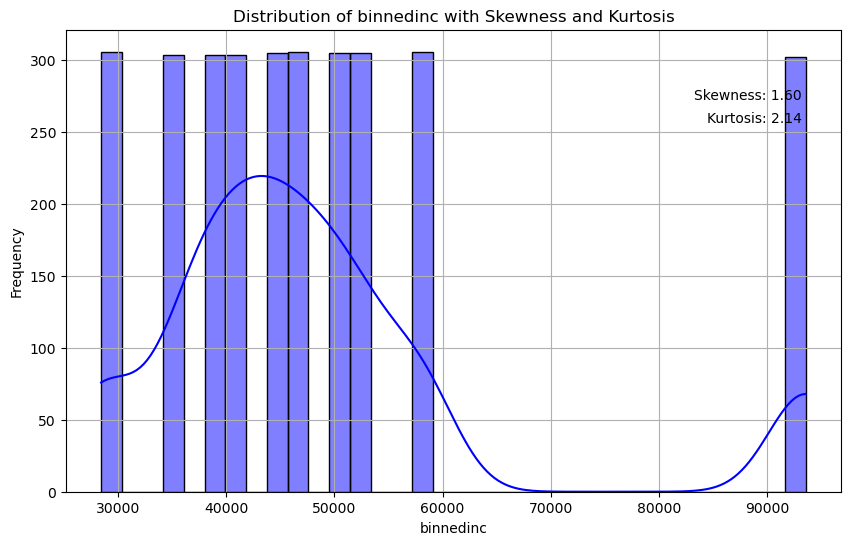

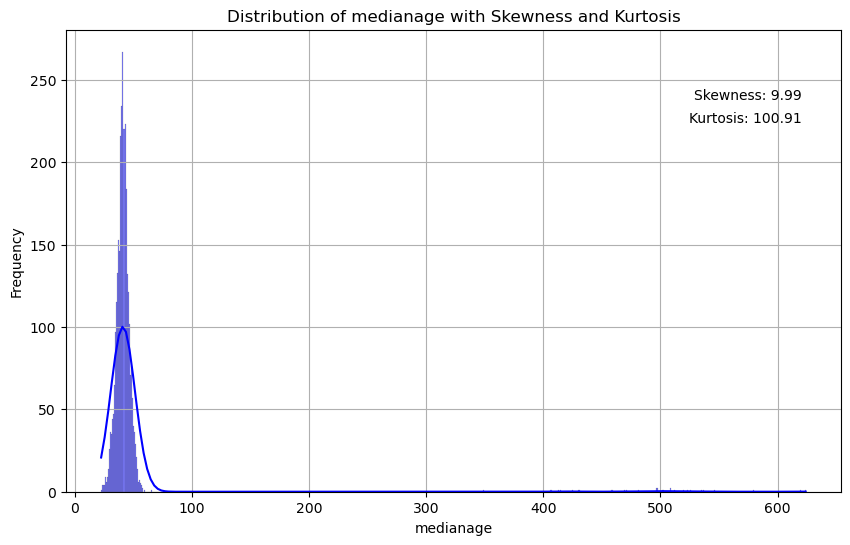

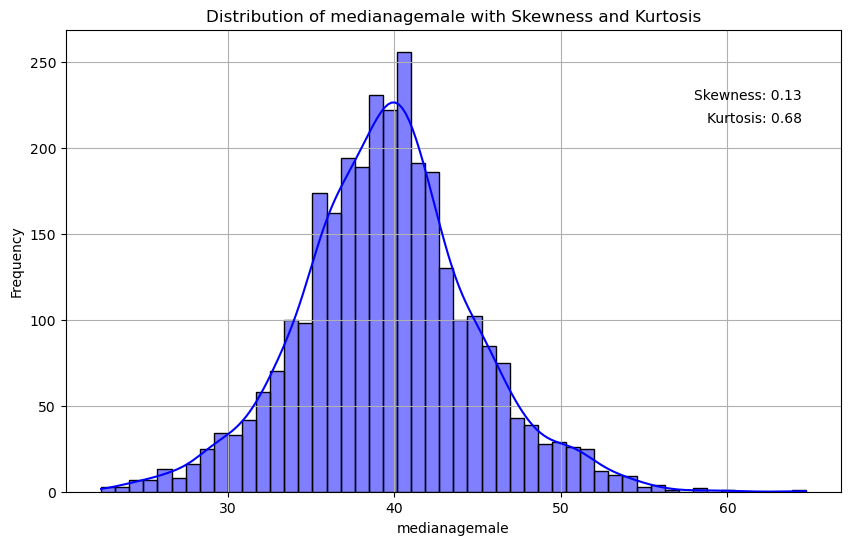

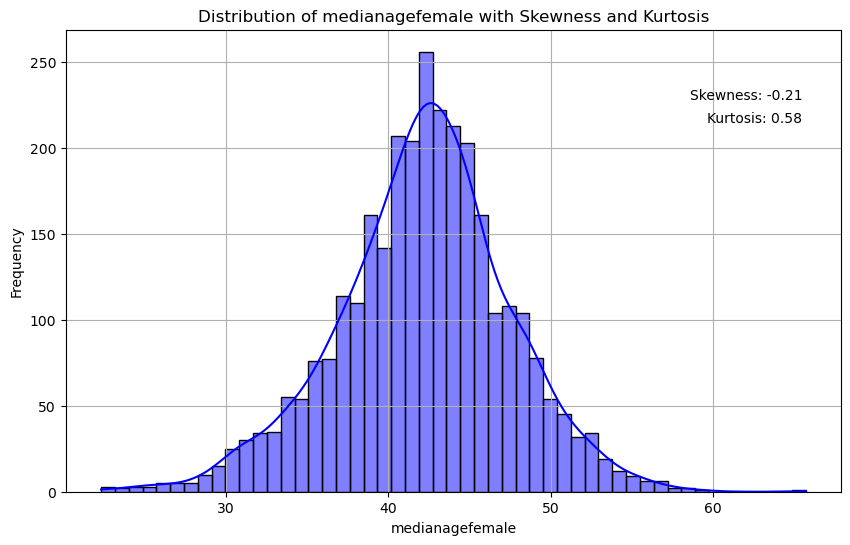

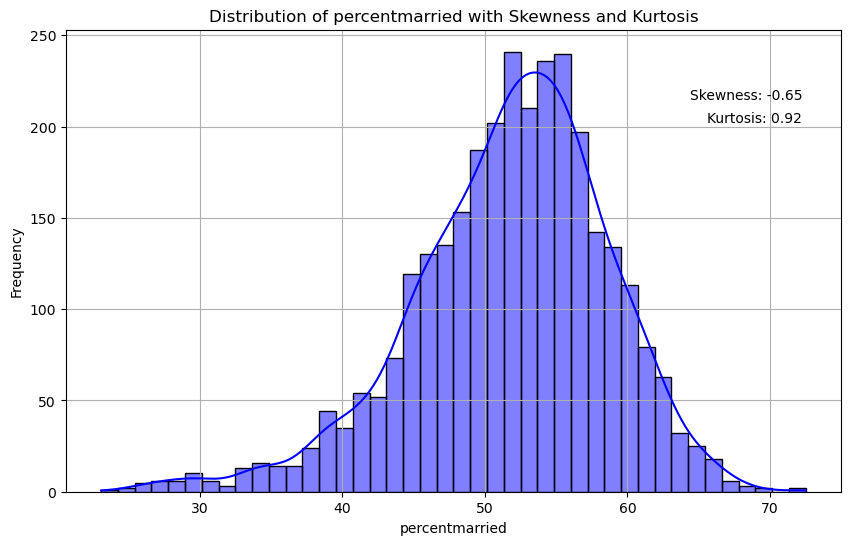

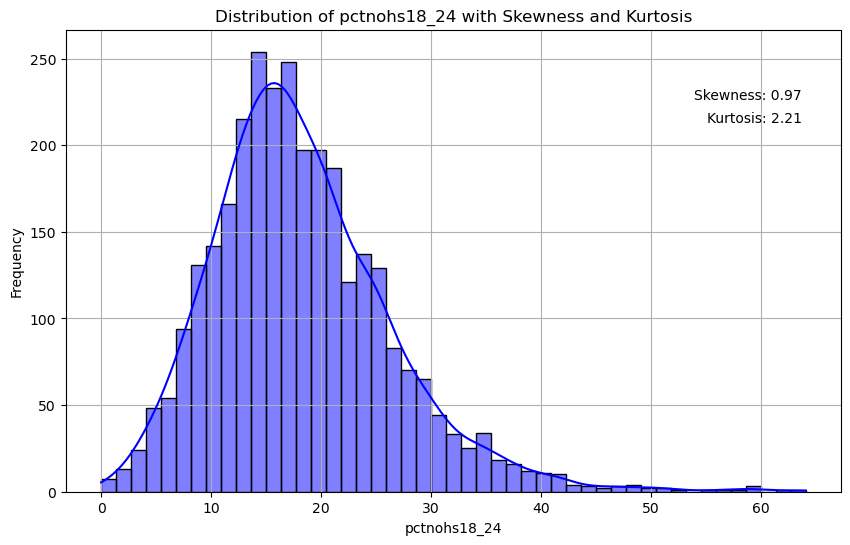

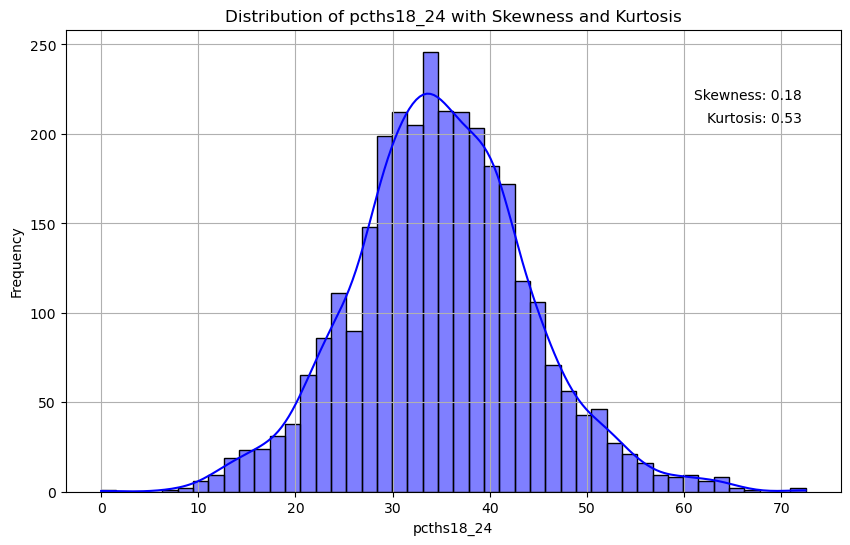

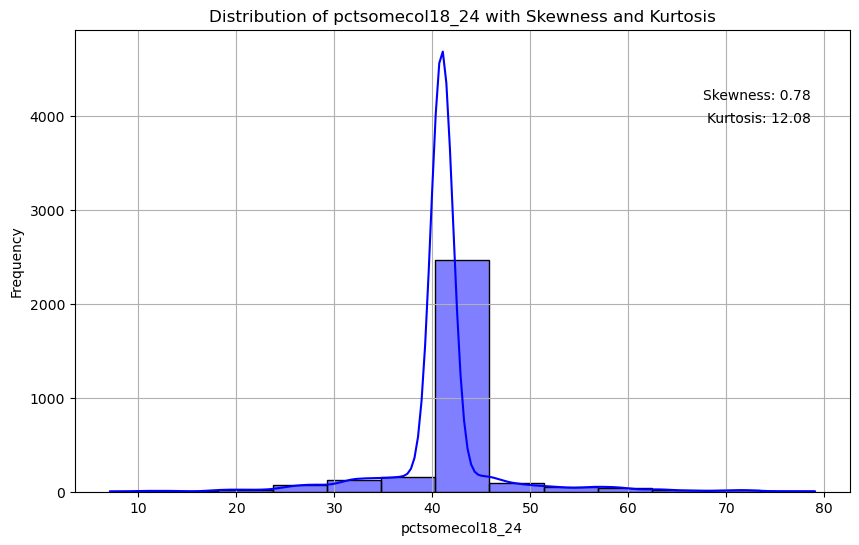

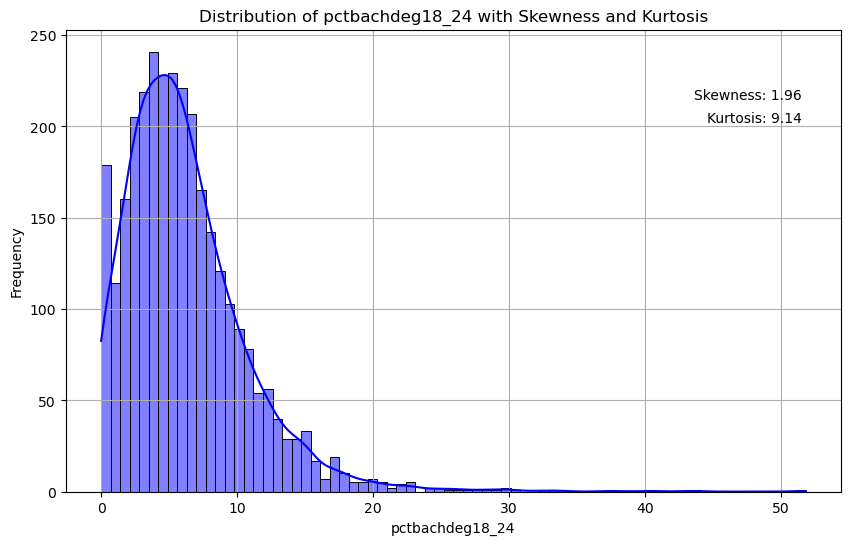

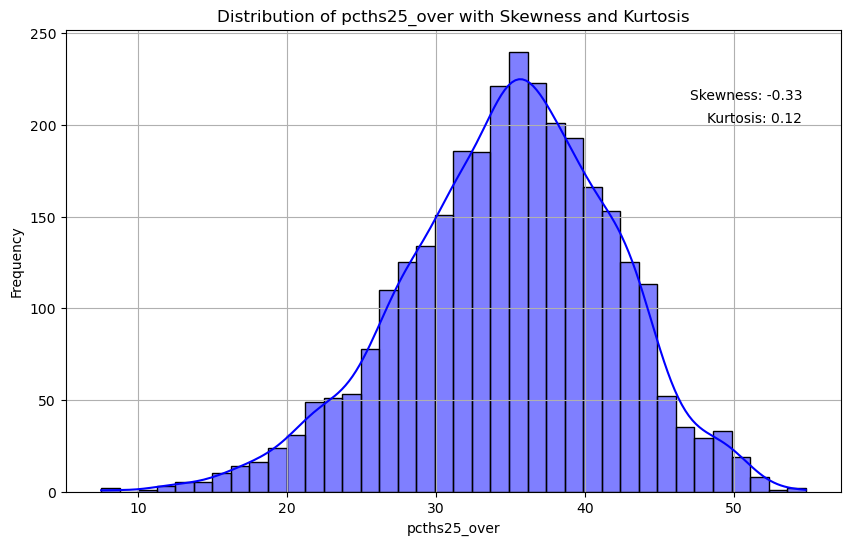

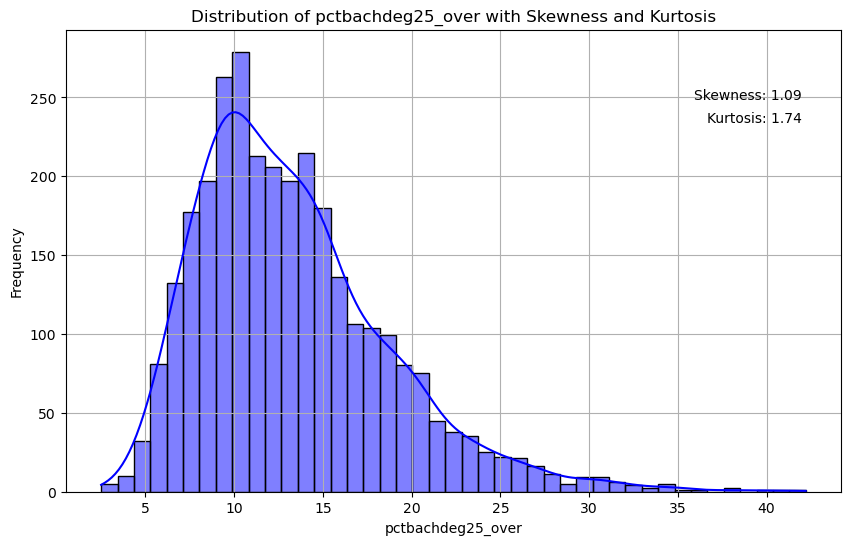

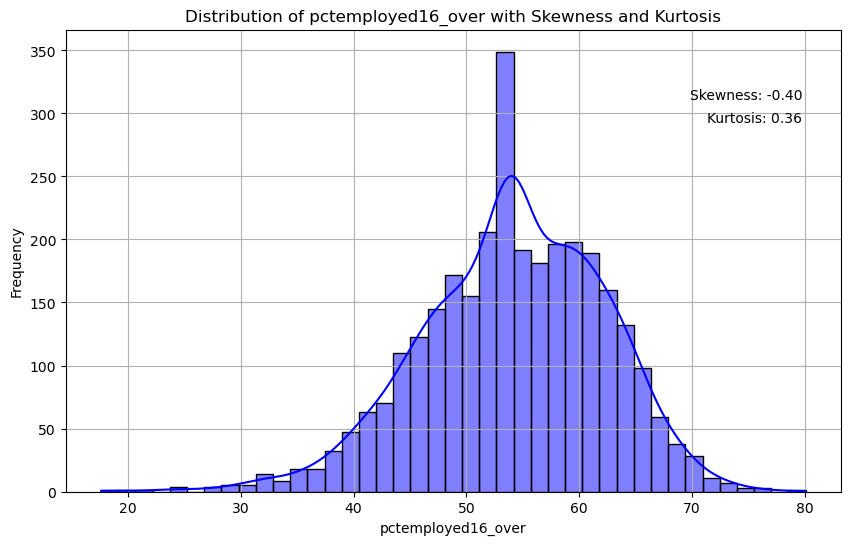

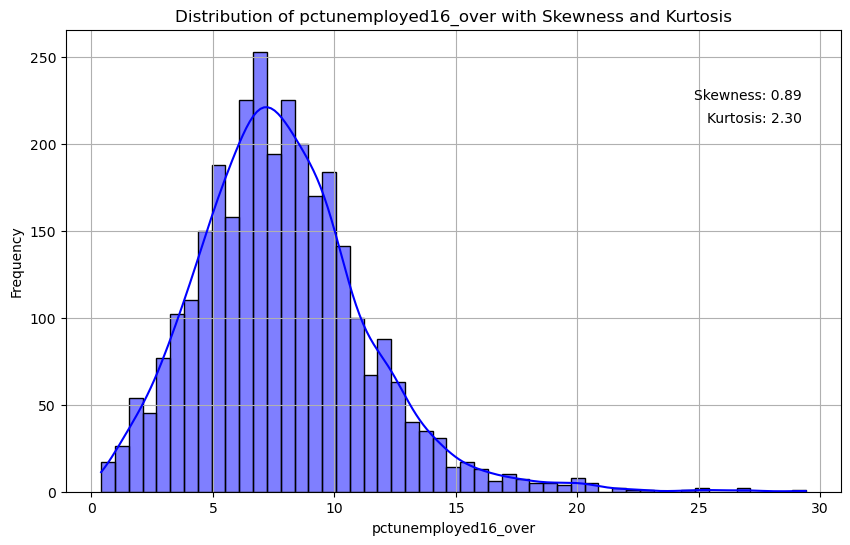

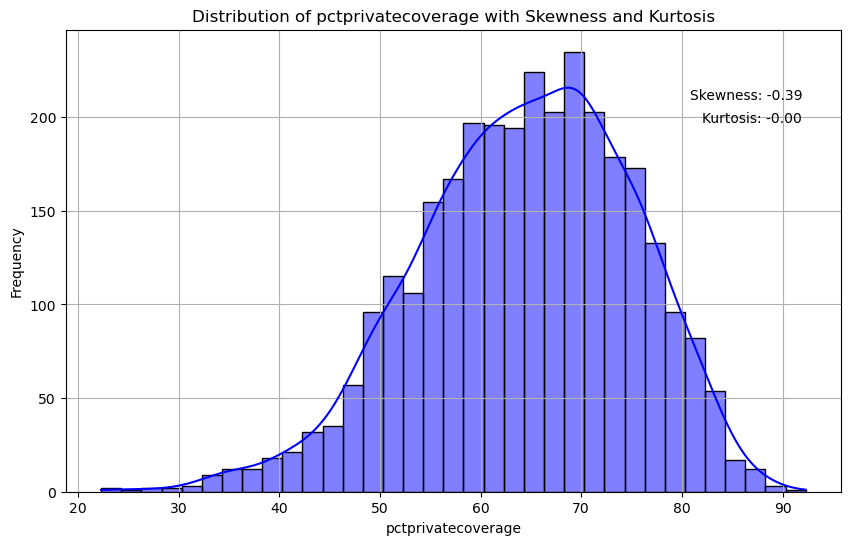

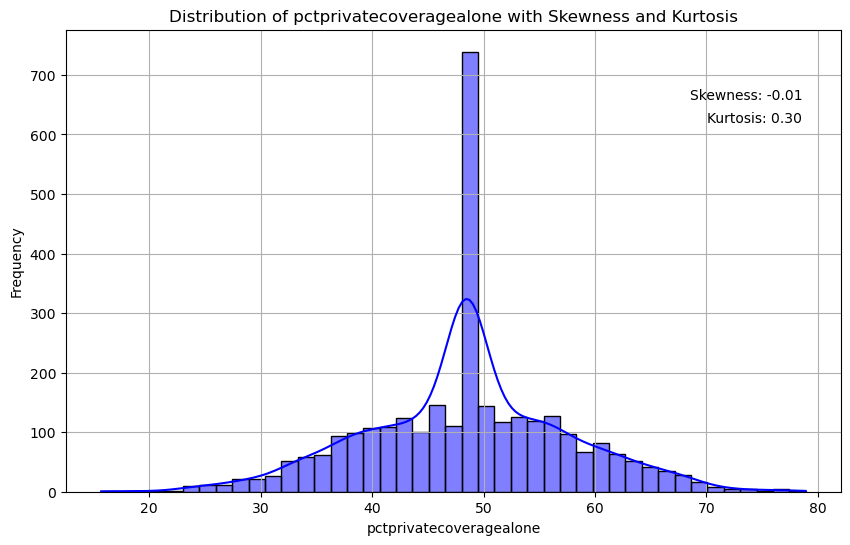

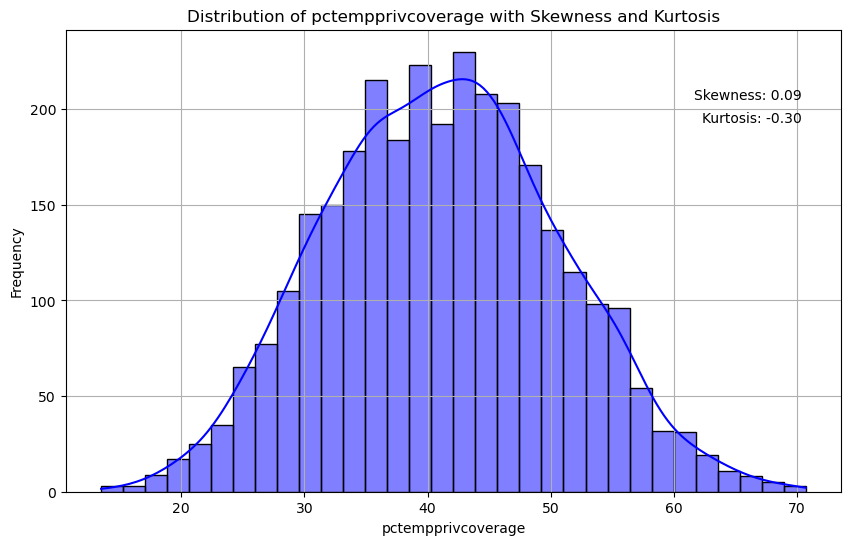

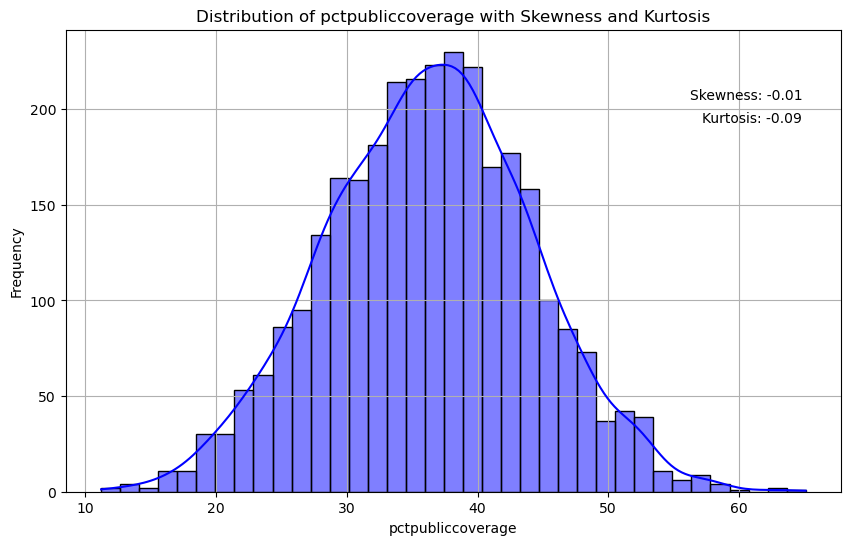

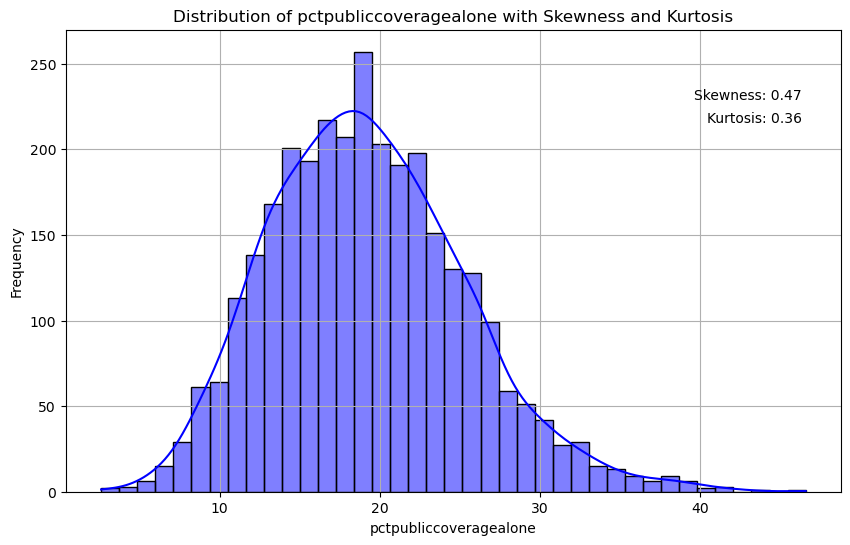

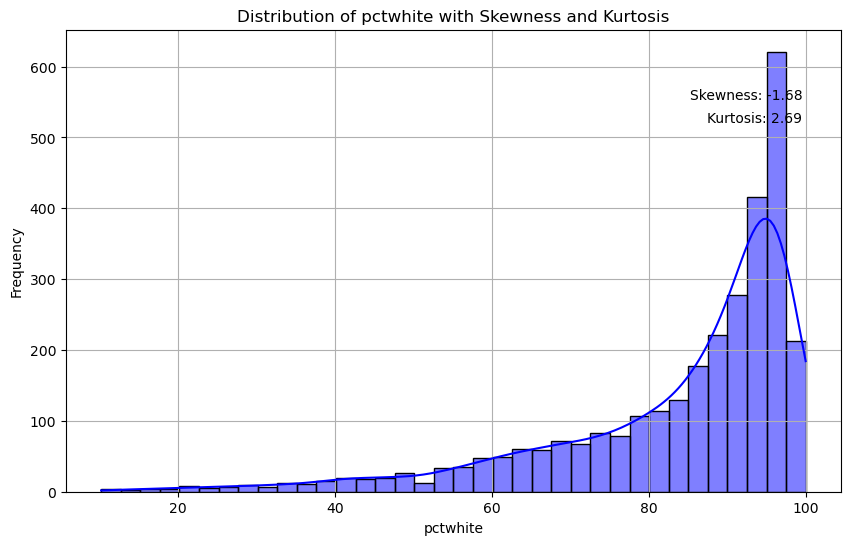

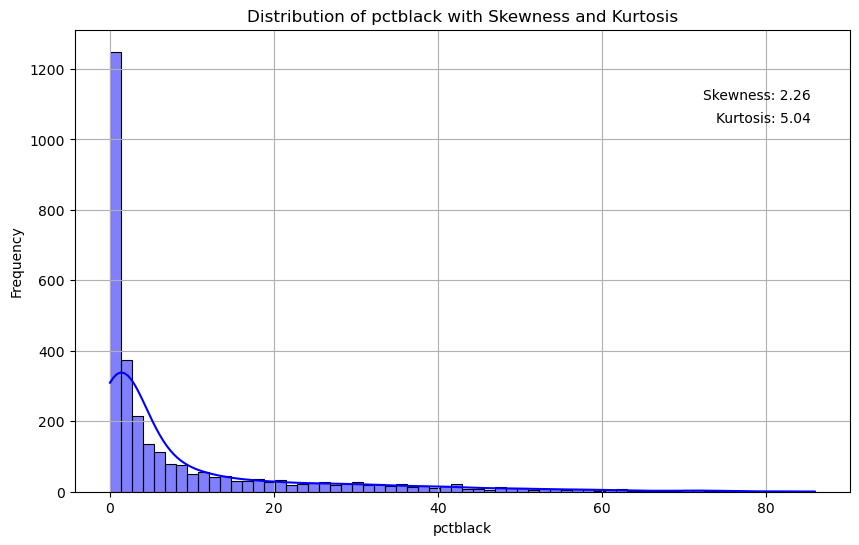

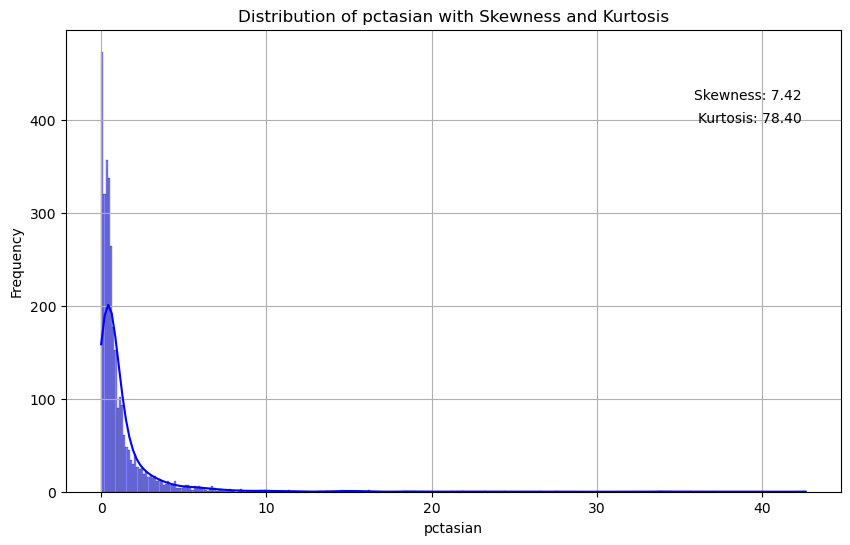

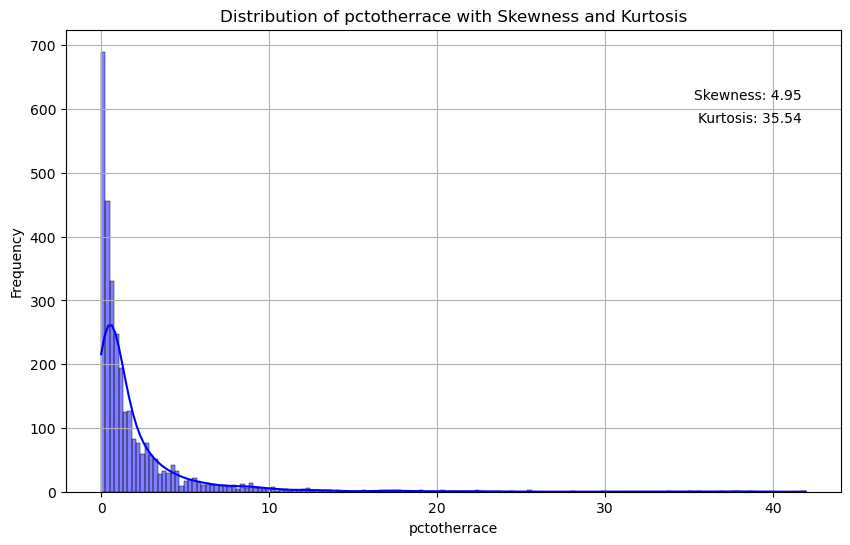

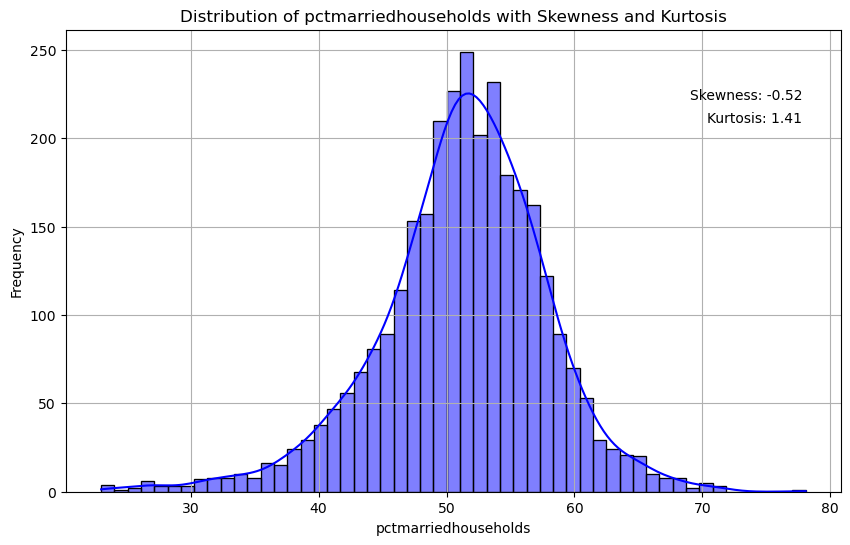

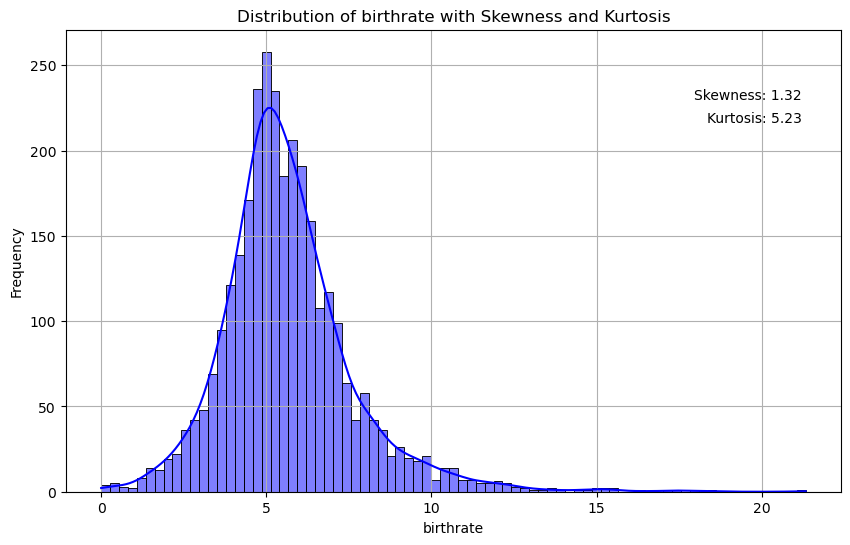

In [24]:
dist_plot(df)

In [ ]:
# df.drop("geography", axis=1, inplace=True)